In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

* Read csv, remove puctuation, stopwords and apply stemming, replace keywords with 'NULL'

In [2]:
tweets = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
tweets['keyword'] = tweets['keyword'].fillna('NULL')
test['keyword'] = test['keyword'].fillna('NULL')

In [3]:
duplicates = tweets.duplicated(subset = 'text', keep = False)
duplicates.value_counts()

False    7434
True      179
dtype: int64

In [4]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7434 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


In [5]:
tweets['keyword'] = tweets.keyword.str.replace('%20',' ')

In [6]:
import string

tweets['text'] = tweets['text'].apply(lambda x: x.translate({ord(i): ' ' for i in string.punctuation}))
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,Our Deeds are the Reason of this earthquake M...,1
1,4,NULL,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NULL,NaN,All residents asked to shelter in place are ...,1
3,6,NULL,NaN,13 000 people receive wildfires evacuation or...,1
4,7,NULL,NaN,Just got sent this photo from Ruby Alaska as ...,1


In [7]:
tweets['text'] = tweets['text'].apply(lambda x: x.lower())

In [8]:
import io
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matiascano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

In [10]:
tweets['text'] = tweets['text'].str.split()
tweets['text'] = tweets['text'].apply(remove_stopword)
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,deeds reason earthquake may allah forgive us,1
1,4,NULL,NaN,forest fire near la ronge sask canada,1
2,5,NULL,NaN,residents asked shelter place notified officer...,1
3,6,NULL,NaN,people receive wildfires evacuation orders cal...,1
4,7,NULL,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [11]:
stemmer = SnowballStemmer('english')

In [12]:
def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [13]:
tweets['text'] = tweets['text'].apply(stemm)
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1
1,4,NULL,NaN,forest fire near la rong sask canada,1
2,5,NULL,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NULL,NaN,peopl receiv wildfir evacu order california,1
4,7,NULL,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


In [14]:
tweets.reset_index(drop=True, inplace=True)

In [15]:
tweets.head()

,id,keyword,location,text,target
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1
1,4,NULL,NaN,forest fire near la rong sask canada,1
2,5,NULL,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NULL,NaN,peopl receiv wildfir evacu order california,1
4,7,NULL,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


### Clustering graphic

* SVD

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(tweets['text'])

In [17]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
svd.fit(x_train_tfidf)
svd_result = svd.transform(x_train_tfidf)

In [18]:
to_plot = pd.DataFrame({'x': svd_result[:, 0], 'y': svd_result[:, 1], 'target': tweets['target']})

In [19]:
to_plot.reset_index(inplace=True, drop=True)

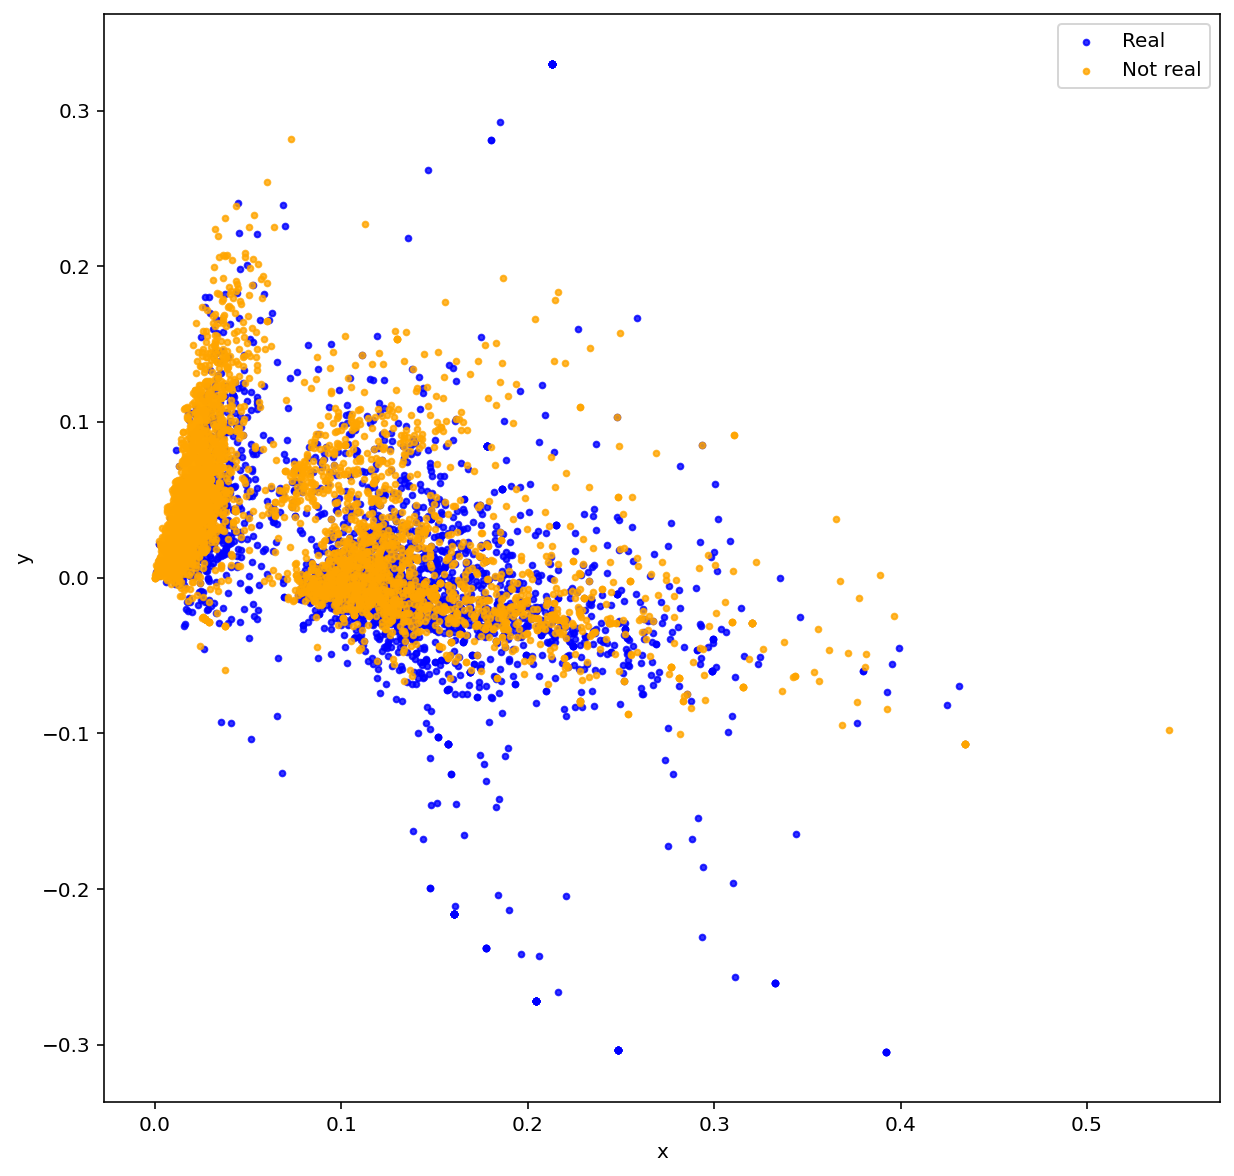

In [20]:
ax = to_plot[to_plot['target'] == 1].plot.scatter(x='x', y='y', s=8, alpha=0.8, color='blue', label='Real', figsize=(10, 10))
to_plot[to_plot['target'] == 0].plot.scatter(x='x', y='y', s=8, alpha=0.8, color='orange', label='Not real', ax=ax)

### TF-IDF matrix

In [23]:
x_train, x_test, y_train, y_test = \
train_test_split(tweets['text'], tweets.loc[:,['id','target']], test_size = 0.25, random_state = 123)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(x_train)
test_vectors = tfidf_vectorizer.transform(x_test)
array = train_vectors.todense()

tfidf_matrix = pd.DataFrame(array)
tfidf_matrix.head(10)

,0,1,2,3,4,5,6,7,8,9,...,11190,11191,11192,11193,11194,11195,11196,11197,11198,11199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_train.reset_index(drop=True, inplace=True)
y_train.head()

,id,target
0,4774,1
1,6820,0
2,1069,0
3,474,0
4,8208,0


#### Basic Naive Bayes 

En el caso de una predicción binaria es recomendable bernoulli

In [25]:
from sklearn.naive_bayes import BernoulliNB

bernoulli = BernoulliNB().fit(train_vectors, y_train['target'])

In [26]:
from sklearn.metrics import accuracy_score
predicted = bernoulli.predict(test_vectors)
print(accuracy_score(y_test['target'], predicted))

0.8128025820333513


#### Tunning

In [27]:
tfidf_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,11190,11191,11192,11193,11194,11195,11196,11197,11198,11199
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
features = tfidf_matrix.columns

In [29]:
alpha = np.linspace(0.5, 1.0, 20)
alpha = np.around(alpha, decimals=4)
alpha

array([0.5   , 0.5263, 0.5526, 0.5789, 0.6053, 0.6316, 0.6579, 0.6842,
       0.7105, 0.7368, 0.7632, 0.7895, 0.8158, 0.8421, 0.8684, 0.8947,
       0.9211, 0.9474, 0.9737, 1.    ])

In [30]:
grid = [{"alpha":alpha}]

In [31]:
from sklearn.model_selection import GridSearchCV

#classifier = BernoulliNB()
#gridsearch = GridSearchCV(classifier, grid, scoring = 'neg_log_loss', cv = 4)
#gridsearch.fit(df[features], y_train['target'])
#print("Best parameter: ",gridsearch.best_params_)

In [32]:
bernoulli_t = BernoulliNB(alpha=0.9474).fit(train_vectors, y_train['target'])
predicted_t = bernoulli_t.predict(test_vectors)
print(accuracy_score(y_test['target'], predicted_t))

0.8138784292630447


### LightGBM

* Count vectorization

In [33]:
from sklearn.metrics import classification_report

In [34]:
x_train, x_test, y_train, y_test = \
train_test_split(tweets[['text', 'keyword']], tweets['target'], test_size = 0.25, random_state = 123)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features=5000)
train_vectors = tfidf_vectorizer.fit_transform(x_train['text'])
test_vectors = tfidf_vectorizer.transform(x_test['text'])

In [35]:
tfidf_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features=300)
key_train_vectors = tfidf_vectorizer.fit_transform(x_train['keyword'])
key_test_vectors = tfidf_vectorizer.transform(x_test['keyword'])

In [36]:
from scipy.sparse import hstack
matrix_final = hstack([train_vectors, key_train_vectors])

In [37]:
matrix_final = matrix_final.astype('float32')

In [38]:
import lightgbm as lgb
d_train = lgb.Dataset(matrix_final, label=y_train)

params = {
    'learning_rate' : 0.02,
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'num_leaves' : 50,
    'max_depth' : 5
}

gbm = lgb.train(params, d_train, 5000)

In [40]:
test_final = hstack([test_vectors, key_test_vectors])
test_final = test_final.astype('float32')
y_pred = gbm.predict(test_final)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1
    else:  
        y_pred[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.8025820333512641


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1055
           1       0.82      0.70      0.75       804

    accuracy                           0.80      1859
   macro avg       0.81      0.79      0.79      1859
weighted avg       0.80      0.80      0.80      1859



### Word2Vec for keywords

In [45]:
keywords = tweets.loc[:,['keyword', 'id']]
keywords.head()

,keyword,id
0,NULL,1
1,NULL,4
2,NULL,5
3,NULL,6
4,NULL,7


In [46]:
keyword_tokens = keywords.keyword.unique().tolist()

In [47]:
keyword_tokens[0]

'NULL'

In [48]:
len(keyword_tokens)

222

In [49]:
from gensim.models import Word2Vec

# Parameters
# sg ({0, 1}, optional) - Training algorithm: 1 for skip-gram; otherwise CBOW.

keyword_vectors = Word2Vec([keyword_tokens], min_count=1, size= 100, workers=3, window =3, sg=1)

In [50]:
# Sanity check
keyword_vectors['ablaze']

/Users/matiascano/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 2.8703855e-03,  1.6447779e-03,  1.9482286e-04,  4.6086093e-04,
       -3.8400206e-03, -2.7447456e-04,  1.2920352e-03,  3.8474863e-03,
        3.2448231e-03,  2.5644933e-03, -1.9011424e-03,  1.2672464e-03,
        2.0250084e-03, -6.8006833e-04, -4.0436313e-03,  1.4549536e-03,
       -4.5451634e-03,  5.0705840e-04,  4.6491041e-03, -4.0771887e-03,
        3.3595683e-03, -1.1459845e-03,  3.2759877e-03, -1.2873422e-03,
        4.0410645e-03, -2.2463696e-03, -4.2038695e-03,  3.0703444e-03,
       -2.3248666e-03, -3.8666159e-03,  2.8123718e-03, -1.2042125e-03,
        4.9729696e-03,  3.7728186e-04, -2.3508614e-03,  4.7875734e-04,
        2.0728183e-03,  1.7812697e-03, -1.9466121e-03, -4.0985169e-03,
       -4.7825258e-03,  1.5576492e-03,  1.8983273e-03,  3.8963844e-05,
       -9.9247473e-04,  3.1326490e-03,  3.2302924e-03,  4.5864419e-03,
       -8.2454004e-04, -1.2002964e-04,  7.3326239e-04,  3.7258433e-03,
       -3.3203166e-03, -1.7969109e-03, -3.4163829e-03, -3.1028632e-03,
      

In [51]:
to_vector_matrix = {}

for k in keyword_tokens:
    to_vector_matrix[k] = keyword_vectors[k]

/Users/matiascano/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [52]:
keyword_w2v = pd.DataFrame.from_dict(to_vector_matrix).T.reset_index()
keyword_w2v

,index,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,NULL,-0.004177,-0.002151,0.000683,-0.003396,-0.000459,0.001611,0.000022,0.001227,0.001389,...,0.002685,0.002350,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961
1,ablaze,0.002870,0.001645,0.000195,0.000461,-0.003840,-0.000274,0.001292,0.003847,0.003245,...,0.000995,-0.000931,-0.000293,-0.000071,-0.001380,0.001395,-0.003851,0.003845,0.001724,-0.003241
2,accident,-0.003583,-0.001722,0.002548,-0.001231,0.004275,0.001024,-0.004348,-0.003127,0.001763,...,0.001054,0.000270,0.004548,0.001322,0.003205,0.002935,0.000629,-0.001776,0.001141,-0.002292
3,aftershock,0.002169,0.001744,0.004307,0.001623,0.001684,-0.004022,0.000805,-0.002487,-0.000616,...,0.002334,0.000356,0.004681,-0.003625,-0.000494,0.004382,0.003684,-0.004760,0.004155,-0.000959
4,airplane accident,-0.004078,-0.003674,0.003871,-0.000813,0.000987,0.003430,0.003615,-0.001194,0.000302,...,-0.000334,0.001599,0.004503,0.003170,0.001944,-0.004905,-0.004296,-0.000354,0.003987,0.003876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,wounded,-0.001223,-0.003539,0.001230,0.001642,0.004987,0.001702,0.004532,-0.000329,0.004236,...,0.001045,-0.001905,-0.001752,0.001410,0.004394,0.004478,0.003528,0.000874,0.001794,0.001082
218,wounds,0.001912,0.002138,0.004967,0.002708,-0.002112,0.000439,-0.003784,-0.000139,0.002216,...,-0.003254,0.004613,0.000744,-0.000013,0.000799,-0.002274,-0.000736,0.001546,-0.002113,-0.001299
219,wreck,0.003762,0.004853,-0.000663,0.004303,0.001784,-0.005026,0.001293,-0.002971,0.004941,...,-0.001672,0.004635,-0.003877,0.002207,0.004984,0.003441,0.003803,0.004110,-0.002972,-0.002139
220,wreckage,0.003511,0.000527,-0.000018,0.004682,-0.004278,-0.003969,-0.000066,-0.002202,0.000787,...,-0.000727,-0.000187,-0.002288,0.003737,-0.001639,-0.002612,-0.004146,0.004406,0.000699,0.001082


In [77]:
keyword_w2v.columns

Index(['index',       0,       1,       2,       3,       4,       5,       6,
             7,       8,
       ...
            90,      91,      92,      93,      94,      95,      96,      97,
            98,      99],
      dtype='object', length=101)

In [85]:
aux = []
aux.append('keyword')
for i in range (0, 100):
    name = 'v' + str(i)
    aux.append(name)
len(aux)

101

In [86]:
keyword_w2v.columns = aux

In [87]:
keyword_w2v.head()

,keyword,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,NULL,-0.004177,-0.002151,0.000683,-0.003396,-0.000459,0.001611,0.000022,0.001227,0.001389,...,0.002685,0.002350,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961
1,ablaze,0.002870,0.001645,0.000195,0.000461,-0.003840,-0.000274,0.001292,0.003847,0.003245,...,0.000995,-0.000931,-0.000293,-0.000071,-0.001380,0.001395,-0.003851,0.003845,0.001724,-0.003241
2,accident,-0.003583,-0.001722,0.002548,-0.001231,0.004275,0.001024,-0.004348,-0.003127,0.001763,...,0.001054,0.000270,0.004548,0.001322,0.003205,0.002935,0.000629,-0.001776,0.001141,-0.002292
3,aftershock,0.002169,0.001744,0.004307,0.001623,0.001684,-0.004022,0.000805,-0.002487,-0.000616,...,0.002334,0.000356,0.004681,-0.003625,-0.000494,0.004382,0.003684,-0.004760,0.004155,-0.000959
4,airplane accident,-0.004078,-0.003674,0.003871,-0.000813,0.000987,0.003430,0.003615,-0.001194,0.000302,...,-0.000334,0.001599,0.004503,0.003170,0.001944,-0.004905,-0.004296,-0.000354,0.003987,0.003876


#### Features

In [65]:
tweets_features = pd.read_csv("train_features.csv")
test_features = pd.read_csv("test_features.csv")

In [68]:
tweets_features.head(1)

,id,text,target,text_without_stopwords,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason May ALLAH Forgive us,69,4.384615,13,13,0.2732,6,1,0,1,7,0.461538,0,6,1,0


In [69]:
test_features.head(1)

,id,text,text_without_stopwords,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,0,Just happened a terrible car crash,Just happened terrible car crash,34,4.833333,6,6,-0.7003,2,0,0,0,8,0.333333,1,2,1,1


In [71]:
tweets_features = tweets_features.drop(columns=['text', 'text_without_stopwords', 'target'])

In [72]:
tweets_features.head(1)

,id,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,1,69,4.384615,13,13,0.2732,6,1,0,1,7,0.461538,0,6,1,0


#### Merge all features

In [118]:
tweets.head(1)

,id,keyword,location,text,target
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1


In [88]:
keyword_w2v.head(1)

,keyword,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,NULL,-0.004177,-0.002151,0.000683,-0.003396,-0.000459,0.001611,0.000022,0.001227,0.001389,...,0.002685,0.00235,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961


In [76]:
tweets_features.head(1)

,id,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords,stopword_word_ratio,adjectives_count,nouns_count,verbs_count,adverbs_count
0,1,69,4.384615,13,13,0.2732,6,1,0,1,7,0.461538,0,6,1,0


In [119]:
merged = tweets.merge(tweets_features, left_on='id', right_on='id')

In [120]:
total_features = merged.merge(keyword_w2v, left_on='keyword', right_on='keyword')

In [122]:
total_features.head()

,id,keyword,location,text,target,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
0,1,NULL,NaN,deed reason earthquak may allah forgiv us,1,69,4.384615,13,13,0.2732,...,0.002685,0.00235,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961
1,4,NULL,NaN,forest fire near la rong sask canada,1,38,4.571429,7,7,-0.3400,...,0.002685,0.00235,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961
2,5,NULL,NaN,resid ask shelter place notifi offic evacu she...,1,133,5.090909,22,20,-0.2960,...,0.002685,0.00235,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961
3,6,NULL,NaN,peopl receiv wildfir evacu order california,1,65,7.125000,8,8,0.0000,...,0.002685,0.00235,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961
4,7,NULL,NaN,got sent photo rubi alaska smoke wildfir pour ...,1,88,4.500000,16,15,0.0000,...,0.002685,0.00235,-0.002253,-0.003299,0.001158,0.001634,-0.001306,-0.000912,0.001187,0.004961


In [141]:
features = total_features.columns
features = features.drop('target')

#### Features with tweet vectorizer

In [238]:
x_train, x_test, y_train, y_test = \
train_test_split(total_features[features], total_features['target'], test_size = 0.25, random_state = 123)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english', max_features=11000)
train_vectors = tfidf_vectorizer.fit_transform(x_train['text'])
test_vectors = tfidf_vectorizer.transform(x_test['text'])

In [239]:
train_array = train_vectors.todense()
train_matrix = pd.DataFrame(train_array)
x_train.reset_index(inplace=True, drop=True)
train_matrix['id'] = x_train['id']
X_train = x_train.merge(train_matrix).drop(columns=['keyword', 'location', 'text', 'id'])

In [240]:
test_array = test_vectors.todense()
test_matrix = pd.DataFrame(test_array)
x_test.reset_index(inplace=True, drop=True)
test_matrix['id'] = x_test['id']
X_test = x_test.merge(test_matrix).drop(columns=['keyword', 'location', 'text', 'id'])

In [269]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, y_train)

params : {
    'learning_rate' : 0.02,
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'num_leaves' : 500,
    'max_depth' : 2,
    'max_bin': 1000
}

gbm = lgb.train(params, d_train, 10000)

In [270]:
y_pred = gbm.predict(X_test)

for i in range (0, len(y_pred)):
    if y_pred[i] > 0.5:       
        y_pred[i] = 1
    else:  
        y_pred[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.7832167832167832


In [271]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1105
           1       0.75      0.71      0.73       754

    accuracy                           0.78      1859
   macro avg       0.78      0.77      0.77      1859
weighted avg       0.78      0.78      0.78      1859



### Character level CNN with Keras
-------